c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


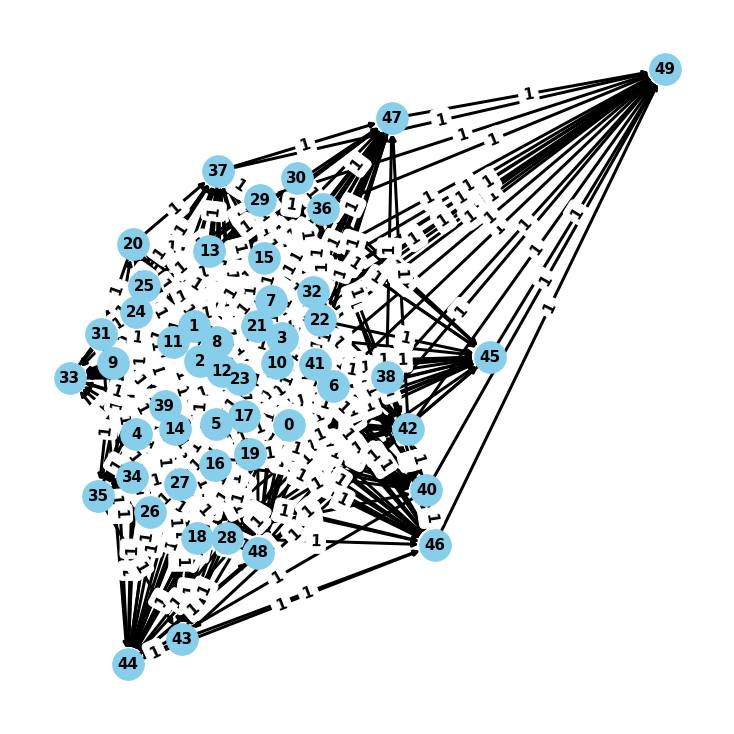

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from pyvis.network import Network

from DAG import DAG

dag = DAG(n = 50, roots = 1, precalculate_paths = False)
dag.plot()

In [9]:
dag.adjacency_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
# dag.adjacency_matrix
sum([np.linalg.matrix_power(dag.adjacency_matrix,i).diagonal().sum() for i in range(1,40)])


0

[0,
 0,
 12,
 32,
 50,
 78,
 245,
 568,
 1083,
 2300,
 5346,
 11822,
 24921,
 54061,
 119852,
 261656,
 565811,
 1232871,
 2698475]

In [12]:
dag.precalculate_paths()

RecursionError: maximum recursion depth exceeded in comparison

In [7]:
# dag.precalculate_paths = False
sim = dag.simulate(100).var(axis = 1)
for i in range(dag.size):
    print("simulated", i, ":", round(sim[i]*10)/10, "| analytical", ":", round(dag.var_node(i)))
    

simulated 0 : 0.8 | analytical : 1
simulated 1 : 1.5 | analytical : 2
simulated 2 : 4.3 | analytical : 6


$V_a = \sum^{nodes}_i\sum_{j,k}\prod^{path_{j}}_j\prod^{path_{ia}}_k W_j W_kV_i + V_a$

In [60]:
from itertools import combinations_with_replacement, combinations, product

for i in combinations_with_replacement(range(dag.size), 2):
    print(i)

print()
for i in product(range(dag.size), range(dag.size)):
    print(i)

(0, 0)
(0, 1)
(0, 2)
(1, 1)
(1, 2)
(2, 2)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [283]:
adj = dag.adjaceny_matrix.copy()

N = 10






adj
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
root 0
here!
adj
 [[0 0 0]
 [0 0 1]
 [0 0 0]]
root 1
here!
adj
 [[0 0 0]
 [0 0 0]
 [0 0 0]]
root 2
here!
adj
 [[0 0 0]
 [0 0 0]
 [0 0 0]]


In [286]:
values.var(axis = 1)

array([0.81126094, 0.8034279 , 4.22545177])

In [245]:
for i in range(dag.size):
    print("variance for node", i, ":",dag.var_node(i))

[array([], dtype=float64)]
[]
[]
variance for node 0 : 1.0
[array([[0, 1]])]
prod 1.0 for [[0 1]] [[0 1]]
[array([], dtype=float64)]
[]
variance for node 1 : 2.0
[array([[0, 1],
       [1, 2]]), array([[0, 2]])]
prod 1.0 for [[0 1]
 [1 2]] [[0 1]
 [1 2]]
prod 1.0 for [[0 1]
 [1 2]] [[0 2]]
prod 1.0 for [[0 2]] [[0 2]]
[array([[1, 2]])]
prod 1.0 for [[1 2]] [[1 2]]
[array([], dtype=float64)]
variance for node 2 : 5.0


In [77]:
def naive(dag):
    sums = np.zeros(dag.shape[0])
    sums[0] = 1

    for i in range(dag.shape[0]):
        unit_vector = np.zeros(dag.shape[0])
        unit_vector[i] = 1

        print(i)
        print(unit_vector @ dag)

        for vec, j in enumerate(unit_vector @ dag):
            sums[vec] += sums[i]*j
            # print(j)

    return sums

# print(naive(dag))
# print(getnum(dag))

In [100]:
# If ( src == dest ) then
# 2.      A path has been found. Push the path in the list of all_the_paths ( list of list ).
# 3.  Else
# 4.     For every adjacent node adj_node that is adjacent to src do
# 5.        Push adj_node in the path.
# 6.        DFS ( adj_node, dest, g )
# 7.        Pop adj_node from the path. This is essentially a backtracking mechanism to find a different path from the source ( src ) node.

# from adjacency matrix to list of edges



find_all_paths(adj2edges(dag), 0, 4)

print(allpaths)

[array([[0, 1],
       [1, 3],
       [3, 4]]), array([[0, 2],
       [2, 3],
       [3, 4]]), array([[0, 2],
       [2, 4]]), array([[0, 4]])]


[array([[0, 1],
        [1, 3],
        [3, 4]]),
 array([[0, 2],
        [2, 3],
        [3, 4]]),
 array([[0, 2],
        [2, 4]]),
 array([[0, 4]])]

In [88]:
adj2edges(dag)

[(0, 1), (0, 2), (0, 4), (1, 3), (2, 3), (2, 4), (3, 4)]

In [37]:
roads = getnum(dag)

biass = np.ones(dag.shape[0]) * 0.5

for i in range(dag.shape[0]):
    

In [ ]:
[1, 1, 1, 4, 9]

In [36]:
getnum(dag)

array([ 1,  1,  1,  4, 36], dtype=int32)

In [19]:
# take the adjancency matrix to the power of 2 to get the number of paths of length 2
roads = np.array([1, 1,1,1])

news = []
for i in range(len(roads)):
    new = roads * np.linalg.matrix_power(dag, i+1).T @ roads
    news.append(np.linalg.matrix_power(dag, i+1).T @ np.array([1,1,1,1]))
    roads[(roads > 0) * (new > 0)] += new[(roads > 0) * (new > 0)]

print(roads)
print(news)

[ 1  2  3 10]
[array([0, 1, 1, 3]), array([0, 0, 1, 2]), array([0, 0, 0, 1]), array([0, 0, 0, 0])]


In [25]:
def getnum(dag):
    plusone = np.zeros(dag.shape[0])
    plusone[0] = 1

    allones = np.ones(dag.shape[0])


    return dag.T @ allones + plusone, 